# SimCLR

In [1]:
from keras import layers, models, regularizers, callbacks, losses

from keras.applications import resnet

# from keras.applications import vgg16

In [3]:
import dpmhm
# dpmhm.datasets.get_dataset_list()
from dpmhm.datasets import preprocessing, transformer, feature, utils
# from dpmhm.models import byol, simclr

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1166721584306666838
xla_global_id: -1
]


2022-11-18 18:01:15.555930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 18:01:15.616436: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-18 18:01:15.616461: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Pluto
2022-11-18 18:01:15.616466: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Pluto
2022-11-18 18:01:15.616602: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-11-18 18:01:15.616622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
20

## Load Data

In [4]:
dataset_name = 'CWRU'

# split0, split1, split2 = tfds.even_splits('train', n=3)

ds_all, ds_info = tfds.load(
    dataset_name, 
    # split='',
    # split=['train[:75%]', 'train[75%:]'],    
    # split=[split1, split2],    
    # download=True,  #
    with_info=True,
    # batch_size=-1,  # load the whole dataset into a single batch
)

ds0 = ds_all['train']

workdir = Path("/home/han/tmp/") / dataset_name

In [5]:
channels = ['DE', 'FE', 'BA']  # will rule out the normal data
# channels = ['DE']  # will rule out the normal data

keys = ['FaultComponent', 'FaultSize']
# keys = ['FaultSize']
# keys = ['FaultComponent']
# keys = []

_extractor = lambda x, sr: feature.spectrogram(x, sr, time_window=0.025, hop_step=0.0125, 
                                              to_db=True, normalize=False)

outdir = workdir / 'spectrogram'
# extractor = lambda x, sr: feature.melspectrogram(x, sr, time_window=0.025, hop_step=0.0125, n_mels=128, normalize=True)
# outdir = Path('/home/han/tmp/cwru/mel')

window_shape = (64, 64)
downsample = (64, 64)

# window_shape = 64
# downsample = 64

In [6]:
compactor = transformer.DatasetCompactor(ds0, keys=keys, channels=channels)
labels = list(compactor.full_label_dict.keys())
N = utils.get_dataset_size(ds0)

extractor = transformer.FeatureExtractor(compactor.dataset, _extractor)

specaugment = transformer.SpecAugment(extractor.dataset)
 
product = transformer.Product(specaugment.dataset, keys=['FileName'], positive=True)

# slider = transformer.WindowSlider(extractor.dataset, window_shape=window_shape, downsample=downsample)
# # fp = tempfile.mkdtemp()
# # slider.serialize(str(workdir), compression='GZIP')
# slider.dataset = tf.data.Dataset.load(str(workdir), compression='GZIP')

# slider.dataset.cardinality()

## SimCLR

In [7]:
ds = product.dataset.map(lambda x,y,v:
                            (tf.transpose(x['feature'],[1,2,0]), tf.transpose(y['feature'],[1,2,0]))
                       )  # to channel-last

batch_size = 16  # from 128 to 4096
ds_size = 100

ds_train = ds.shuffle(ds_size, reshuffle_each_iteration=True).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

ele = list(ds.take(1))[0]
input_shape = ele[0].shape

# print(ds_train.element_spec)

# ele = list(ds_train.take(1))[0]
# X = tf.reshape(ele[0], [16,-1])
# Y = tf.reshape(ele[1], [16,-1])

In [61]:
optimizer = tfm.optimization.lars_optimizer.LARS(
    learning_rate=0.2*batch_size/256,
    weight_decay_rate=1.5e-6
)

model = simclr.SimCLR(input_shape, train_encoder=True)

model.compile(optimizer=optimizer, run_eagerly=True)

# callbacks = [byol.BYOL_Callback()]

In [62]:
model.fit(ds_train, epochs=10)

Epoch 1/10
Eager execution mode: True
      1/Unknown - 5s 5s/step - loss: -0.7405Eager execution mode: True
      2/Unknown - 6s 886ms/step - loss: -0.8940Eager execution mode: True
      3/Unknown - 7s 883ms/step - loss: -0.9306Eager execution mode: True
      4/Unknown - 8s 892ms/step - loss: -0.7947Eager execution mode: True
      5/Unknown - 9s 942ms/step - loss: -0.8098Eager execution mode: True
      6/Unknown - 10s 964ms/step - loss: -0.8052Eager execution mode: True
7/7 [==============================] - 14s 1s/step - loss: -3.3179
Epoch 2/10
Eager execution mode: True
7/7 [==============================] - 6s 919ms/step - loss: -3.6695
Epoch 3/10
Eager execution mode: True
7/7 [==============================] - 7s 943ms/step - loss: -3.9634
Epoch 4/10
Eager execution mode: True
4/7 [================>.............] - ETA: 2s - loss: -1.8998Eager execution mode: True


KeyboardInterrupt: 

In [93]:
tf.gather(ds.take(1),0)

ValueError: Attempt to convert a value (<TakeDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>) to a Tensor.

In [99]:
ds

<MapDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None))>

In [90]:
tf.tuple(ds.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None))>

In [85]:
list(ds.take(1))

[(<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
  array([[[ -8.906312  ,   0.80845696, -15.292098  ],
          [-12.434188  ,   0.89803064, -13.727326  ],
          [-11.545893  ,   2.237683  , -15.903002  ],
          ...,
          [-11.014091  ,  -1.7884495 , -17.79422   ],
          [-10.6556425 ,  -1.6783234 , -13.30192   ],
          [ -9.288587  ,  -3.3674285 , -14.705151  ]],
  
         [[-18.718443  ,  -7.3679657 , -18.771648  ],
          [-11.653357  ,  -4.8432736 , -17.643713  ],
          [-13.004693  ,  -7.2812505 , -17.318964  ],
          ...,
          [-13.39886   ,  -7.835295  , -22.006712  ],
          [-16.733265  ,  -8.238567  , -20.379309  ],
          [-11.282479  ,  -4.2136517 , -11.25413   ]],
  
         [[-15.679877  ,  -6.043933  , -18.913162  ],
          [-12.309805  ,  -3.0179968 , -18.574183  ],
          [-13.082104  ,  -8.673551  , -24.633266  ],
          ...,
          [-12.913424  ,  -3.9442835 , -15.432544  ],
          [-12.759123  ,  -7

# EOF

In [8]:
batch_size = 16

ds_size = 5000
ds_train = ds_split['train'].shuffle(ds_size, reshuffle_each_iteration=True).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].shuffle(ds_size, reshuffle_each_iteration=True).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_split['test'].shuffle(ds_size, reshuffle_each_iteration=True).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ds_train = ds_split['train'].cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
# ds_val = ds_split['val'].cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
# # ds_val = ds_split['val'].cache().prefetch(tf.data.AUTOTUNE)
# ds_test = ds_split['test'].cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# print(len(ds_split['train']))
# print(len(ds_train))

In [9]:
ele = takesample(ds_split['train'])
input_shape = ele[0].shape
n_classes = len(labels)+1  # must add one for the outlier class, Keras uses zero-based class labels.

print(n_classes, input_shape)

30 (64, 64, 3)


## Auto Encoder

In [129]:
from dpmhm.models import autoencoder

n_bands, n_frames, n_channels = input_shape

params = autoencoder.Params(n_bands=n_bands, n_frames=n_frames, n_channels=n_channels, 
                            n_embedding=128, 
                            padding='same',
                            kernel_size=(7,7),
                            activation='relu',                            
                            )
print(params)

# model.summary()

# l=model.get_layer('classifier')

Params(n_channels=3, n_bands=64, n_frames=64, n_embedding=128, kernel_size=(7, 7), activation='relu', padding='same', pool_size=(2, 2), strides=(2, 2))


In [130]:
model = autoencoder.CAES(params)

# model.summary()
model.encoder.summary()
model.decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_enc (Conv2D)          (None, 64, 64, 32)        4736      
                                                                 
 pool1_enc (MaxPooling2D)    (None, 32, 32, 32)        0         
                                                                 
 conv2_enc (Conv2D)          (None, 32, 32, 64)        100416    
                                                                 
 pool2_enc (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 fc1_enc (Dense)             (None, 128)               2097280   
                                                                 
Total params: 2,202,432
Trainable params: 2,202,432
Non-tra

In [131]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    # metrics=['accuracy'],
)

In [132]:
history = model.fit(
    ds_train.map(lambda x,l:(x,x)),
    validation_data=ds_val.map(lambda x,l:(x,x)),
    epochs=100,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)


Epoch 1/100
204/204 [==============================] - 4s 19ms/step - loss: 84.4303 - val_loss: 47.5491
Epoch 2/100
204/204 [==============================] - 3s 17ms/step - loss: 42.1183 - val_loss: 38.6434
Epoch 3/100
204/204 [==============================] - 4s 17ms/step - loss: 41.2846 - val_loss: 37.0645
Epoch 4/100
204/204 [==============================] - 4s 17ms/step - loss: 35.7973 - val_loss: 34.5082
Epoch 5/100
204/204 [==============================] - 3s 17ms/step - loss: 34.5438 - val_loss: 33.8188
Epoch 6/100
204/204 [==============================] - 3s 17ms/step - loss: 33.9629 - val_loss: 33.6864
Epoch 7/100
204/204 [==============================] - 3s 17ms/step - loss: 33.5555 - val_loss: 33.1814
Epoch 8/100
204/204 [==============================] - 3s 17ms/step - loss: 33.4977 - val_loss: 33.2551
Epoch 9/100
204/204 [==============================] - 3s 17ms/step - loss: 33.5557 - val_loss: 32.8815
Epoch 10/100
204/204 [==============================] - 3s 17ms/

In [135]:
x, _ = takesample(ds_val)
y = model(x)

In [136]:
ch = 2
n = 2
a = x[n][:,:,ch]
b = y[n][:,:,ch]

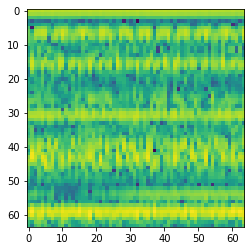

In [137]:
plt.imshow(a)

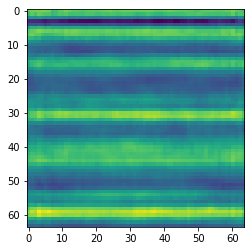

In [138]:
plt.imshow(b)

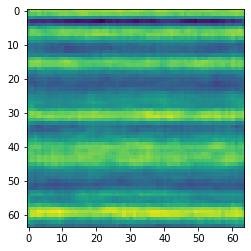

In [126]:
plt.imshow(b)

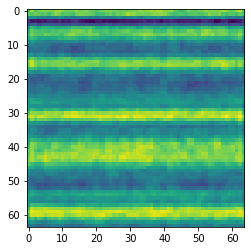

In [116]:
plt.imshow(b)

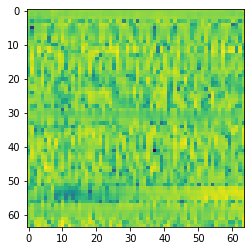

In [139]:
plt.imshow(a-b)

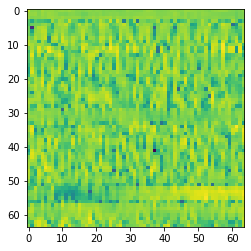

In [127]:
plt.imshow(a-b)

In [36]:
pdb

Automatic pdb calling has been turned OFF


In [29]:
model.save("/home/han/tmp/cwru/mel/full_domain/{'train': 0.7, 'val': 0.2, 'test': 0.1}/vggish")
# model = keras.models.load_model('/home/han/tmp/cwru/vggish')

INFO:tensorflow:Assets written to: /home/han/tmp/cwru/mel/full_domain/{'train': 0.7, 'val': 0.2, 'test': 0.1}/vggish/assets


INFO:tensorflow:Assets written to: /home/han/tmp/cwru/mel/full_domain/{'train': 0.7, 'val': 0.2, 'test': 0.1}/vggish/assets


In [16]:
model.evaluate(ds_test)

72/72 [==============================] - 1s 13ms/step - loss: 19.4831 - accuracy: 0.0373


[19.483142852783203, 0.0373263880610466]

### Keras implementation with transfer learning

In [25]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape, classes=n_classes)

base_model.trainable = False

inputs = base_model.layers[0].input
# layer = keras.layers.BatchNormalization()
# layer.build((None, 4))  # Create the weights

x = base_model(inputs, training=False)
x = keras.layers.Flatten(name="flatten")(x)
x = keras.layers.Dense(4096, activation="relu", name="fc1")(x)
x = keras.layers.Dense(4096, activation="relu", name="fc2")(x)
outputs = keras.layers.Dense(n_classes, activation=None, name="predictions")(x)

model = keras.Model(inputs, outputs)

from_logits = 'softmax' not in str(model.get_layer('predictions').activation)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [26]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/100
175/175 [==============================] - 10s 54ms/step - loss: 17.4417 - accuracy: 0.2467 - val_loss: 3.3726 - val_accuracy: 0.0325
Epoch 2/100
175/175 [==============================] - 5s 31ms/step - loss: 3.1713 - accuracy: 0.2799 - val_loss: 3.4204 - val_accuracy: 0.0410
Epoch 3/100
175/175 [==============================] - 5s 31ms/step - loss: 3.7078 - accuracy: 0.1040 - val_loss: 3.3824 - val_accuracy: 0.0410
Epoch 4/100
175/175 [==============================] - 6s 31ms/step - loss: 3.4660 - accuracy: 0.0189 - val_loss: 3.3006 - val_accuracy: 0.0410
Epoch 5/100
175/175 [==============================] - 6s 32ms/step - loss: 3.3705 - accuracy: 0.0036 - val_loss: 3.2551 - val_accuracy: 0.0509
Epoch 6/100
 95/175 [===============>..............] - ETA: 2s - loss: 3.3426 - accuracy: 0.0092

KeyboardInterrupt: 

In [ ]:
model.evaluate(ds_test)

#### Fine tuning?

In [37]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [38]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/10


2022-10-10 12:32:09.541075: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-10 12:32:09.541103: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-10 12:32:09.684057: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-10 12:32:09.684083: W tensorflow/core/common_runtime/bfc_allocato

59/59 [==============================] - 10s 147ms/step - loss: 0.1297 - accuracy: 0.9560 - val_loss: 0.4328 - val_accuracy: 0.8883
Epoch 2/10
59/59 [==============================] - 8s 132ms/step - loss: 0.0419 - accuracy: 0.9903 - val_loss: 0.4784 - val_accuracy: 0.8837
Epoch 3/10
59/59 [==============================] - 8s 132ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.2635 - val_accuracy: 0.9368
Epoch 4/10
59/59 [==============================] - 8s 132ms/step - loss: 8.2527e-04 - accuracy: 1.0000 - val_loss: 0.2657 - val_accuracy: 0.9374
Epoch 5/10
59/59 [==============================] - 8s 133ms/step - loss: 4.5299e-04 - accuracy: 1.0000 - val_loss: 0.2463 - val_accuracy: 0.9408
Epoch 6/10
59/59 [==============================] - 8s 132ms/step - loss: 2.4925e-04 - accuracy: 1.0000 - val_loss: 0.2452 - val_accuracy: 0.9426
Epoch 7/10
59/59 [==============================] - 8s 131ms/step - loss: 2.0701e-04 - accuracy: 1.0000 - val_loss: 0.2445 - val_accuracy: 0.9429


In [39]:
model.evaluate(ds_test)

30/30 [==============================] - 1s 18ms/step - loss: 0.2598 - accuracy: 0.9399


[0.25981733202934265, 0.9399141669273376]

In [58]:
a = []

for x in dw_split['test']:
    # b = preprocessor.label_dict[x['label'].numpy().decode()]
    a.append(x['metadata']['RPM_Nominal'].numpy())

set(a)

{1730}

# EOF

In [71]:
config = {
    'channels': ['DE', 'FE', 'BA'],  # will rule out the normal data
    'keys': ['FaultComponent', 'FaultSize'],

    'feature': {
        'extractor': 'spectrogram',
        'parameters': {
            'time_window': 0.025,
            'hop_step': 0.0125,
        }
    },
    
    'window': {
        'window_shape': (64,64),
        'downsample': (64,64)               
    },
    
    'splits': {'train':0.2, 'val':0.7, 'test':0.1},

    'sp_kwargs': {
        'shuffle_size': None,
        'reshuffle_each_iteration': False,
    }
}

import json

with open('/home/han/tmp/cwru.json', 'w') as fp:
    json.dump(config, fp)

with open('/home/han/tmp/cwru.yaml', 'w') as fp:
    yaml.dump(config, fp)

#### Statistics on the training data

In [23]:
counter = {}

for x in dw_split['val']:
    d = x['metadata']['RPM_Nominal'].numpy()
    l = x['label'].numpy()
    try:
        counter[(d,l)] += 1
    except:
        counter[(d,l)] = 1

ks = list(counter.keys())
ks.sort()
# {k:counter[k] for k in ks}

# counter

# All categories are present

assert len(set([k[1].decode() for k in ks])) == len(label_dict)

# All categories are present

aa = {}
for k in ks:
    try:
        aa[k[1].decode()].append(k[0])
    except:
        aa[k[1].decode()] = [k[0]]

# [len([k[1] for k in ks if k[0]==lf]) for lf in [1797, 1772, 1750, 1730]]

dm = {}

for k in ks:
    try:
        dm[k[1]][k[0]] += counter[(k[0],k[1])]
    except:
        try:
            dm[k[1]][k[0]] = counter[(k[0],k[1])]
        except:
            dm[k[1]] = {k[0]: counter[(k[0],k[1])]}

{k: np.sum(list(v.values())) for k,v in dm.items()}

In [5]:
# # step 1: compact & split
# compactor = cwru.DatasetCompactor(ds0,
#                                   # filters={'LoadForce': [0,1,2,3]}, 
#                                   n_trunk=n_trunk,
#                                   keys=keys, channels=channels, 
#                                   # resampling_rate=12000,
#                                  )

# labels = compactor.label_dict.keys()
# splits = {'train':0.7, 'val':0.2, 'test':0.1}
# # splits = {'train':1.}

# %time ds_split = utils.split_dataset(compactor.dataset, splits, labels=labels, reshuffle_each_iteration=False)

# # print(utils.get_dataset_size(compactor.dataset))

# # for k, ds in ds_split.items():
# #     print(k, utils.get_dataset_size(ds))    

# # step 2: feature transform
# # df_split = {}
# dw_split = {}

# for k, ds in ds_split.items():
#     transformer = cwru.FeatureTransformer(ds, extractor,                                     
#                                         window_shape=window_shape, downsample=downsample)                                    
#     # df_split[k] = transformer.dataset_feature
#     dw_split[k] = transformer.dataset_windows

# # for k, ds in df_split.items():
# #     print(k, utils.get_dataset_size(ds))    

# # # shoud give the same ratio as defined in `splits`
# # for k, ds in dw_split.items():
# #     print(k, utils.get_dataset_size(ds))    

# # export the feature-transformed dataset for reuse.
# for k,v in dw_split.items():
#     v.save(str(outdir/'full_domain'/str(splits)/k))

In [13]:
dc_kwargs = {
    'n_trunk': n_trunk,
    'keys': keys,
    'channels': channels,
    # 'filters': {'LoadForce': [0,1,2]}
}

ft_kwargs = {
    'window_shape': window_shape,
    'downsample': downsample
}

splits = {'train':0.2, 'val':0.7, 'test':0.1}

# sp_kwargs = {
#     'shuffle_size': 1,
#     'reshuffle_each_iteration': False,
# }

dw_split = preprocessing.wav2feature_pipeline(ds0, 'cwru', extractor, 
                                  dc_kwargs=dc_kwargs, ft_kwargs=ft_kwargs,
                                  splits=splits, sp_mode='fewshot')

for k,v in dw_split.items():
    v.save(str(outdir/'full_domain'/str(splits)/k))    

2022-10-09 10:08:44.252376: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: ValueError: window shape cannot be larger than input array shape
Traceback (most recent call last):

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filei8qexo52.py", line 8, in <lambda>
    tf__lam = (lambda X: ag__.with_function_scope((lambda lscope: (X['label'], X['metadata'], ag

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_6_device_/job:localhost/replica:0/task:0/device:CPU:0}} ValueError: window shape cannot be larger than input array shape
Traceback (most recent call last):

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filei8qexo52.py", line 8, in <lambda>
    tf__lam = (lambda X: ag__.with_function_scope((lambda lscope: (X['label'], X['metadata'], ag__.converted_call(tf.py_function, (), dict(func=ag__.autograph_artifact((lambda S: ag__.converted_call(_slider, (ag__.converted_call(S.numpy, (), None, lscope), window_shape, downsample), None, lscope))), inp=[X['feature']], Tout=tf.float64), lscope))), 'lscope', ag__.STD))

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 459, in _call_unconverted
    return f(*args)

  File "/home/han/Projects/HIASCI/Codes/dpmhm/dpmhm/datasets/preprocessing.py", line 301, in _slider
    return  sliding_window_view(S, (S.shape[0], *ws))[0, ::ds[0], ::ds[1]]

  File "<__array_function__ internals>", line 5, in sliding_window_view

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/numpy/lib/stride_tricks.py", line 331, in sliding_window_view
    raise ValueError(

ValueError: window shape cannot be larger than input array shape


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [ ]:
dw_split = {}

# for p in (outdir/'full_domain'/"{'train': 0.2, 'val': 0.7, 'test': 0.1}").iterdir():
for p in (outdir/'full_domain'/str(splits)).iterdir():
    dw_split[p.name] = tf.data.Dataset.load(str(p))           

# Loading from files makes the size information available 
for k, ds in dw_split.items():
    print(k, utils.get_dataset_size(ds))    

2022-10-09 10:08:44.603990: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: ValueError: window shape cannot be larger than input array shape
Traceback (most recent call last):

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/home/han/.conda/envs/dev38/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filei8qexo52.py", line 8, in <lambda>
    tf__lam = (lambda X: ag__.with_function_scope((lambda lscope: (X['label'], X['metadata'], ag

In [4]:
dw.save(str(outdir/'frames_target_domain'))
dw.save(str(outdir/'partial_domain'/str(splits)/'test'))    
dw = tf.data.Dataset.load(str(outdir/'frames_target_domain'))
# dw_split[p.name] = tf.data.Dataset.load(str(p))      

In [12]:
for k,v in dw_split.items():
    v.save(str(outdir/'partial_domain'/str(splits)/k))    

In [20]:
dw_split = {}

for p in (outdir/'partial_domain'/str(splits)).iterdir():
    dw_split[p.name] = tf.data.Dataset.load(str(p))      
    
# Loading from files makes the size information available 
for k, ds in dw_split.items():
    print(k, len(ds))        

val 1623
train 459
test 246


In [4]:
# Target domain

dc_kwargs = {
    # 'n_trunk': 1,
    'keys': keys,
    'channels': channels,
    'filters': {'LoadForce': [3]}
}

ft_kwargs = {
    'window_shape': window_shape,
    'downsample': downsample
}

dw = preprocessing.wav2feature_pipeline(ds0, 'cwru', extractor, dc_kwargs=dc_kwargs, ft_kwargs=ft_kwargs)

dw.save(str(outdir/'frames_target_domain'))
dw.save(str(outdir/'partial_domain'/str(splits)/'test'))    
dw = tf.data.Dataset.load(str(outdir/'frames_target_domain'))
# dw_split[p.name] = tf.data.Dataset.load(str(p))      


In [12]:
# splits = {'train':0.2, 'test':0.8}

sp_kwargs = {
    'shuffle_size': None,
    'reshuffle_each_iteration': False,
}

dw_split = utils.split_dataset(dw, splits, labels=label_dict.keys(), **sp_kwargs)

for k,v in dw_split.items():
    v.save(str(outdir/'partial_domain'/str(splits)/k))    

In [20]:
dw_split = {}

for p in (outdir/'partial_domain'/str(splits)).iterdir():
    dw_split[p.name] = tf.data.Dataset.load(str(p))      
    
# Loading from files makes the size information available 
for k, ds in dw_split.items():
    print(k, len(ds))        

val 1623
train 459
test 246


In [13]:
# Source domain

dc_kwargs = {
    'n_trunk': n_trunk,
    'keys': keys,
    'channels': channels,
    # 'filters': {'LoadForce': [0,1,2]}
}

ft_kwargs = {
    'window_shape': window_shape,
    'downsample': downsample
}

# sp_kwargs = {
#     'shuffle_size': 1,
#     'reshuffle_each_iteration': False,
# }

dw_split = preprocessing.pipeline(ds0, 'cwru', extractor, 
                                  dc_kwargs=dc_kwargs, ft_kwargs=ft_kwargs,
                                  splits=splits, sp_mode='uniform')

for k,v in dw_split.items():
    v.save(str(outdir/'partial_domain'/str(splits)/k))    

In [23]:
# Target domain

dc_kwargs = {
    'n_trunk': n_trunk,
    'keys': keys,
    'channels': channels,
    'filters': {'LoadForce': [3]}
}

# splits = {'train':0.2, 'test':0.8}
# splits = {'test': 1.}

dw = preprocessing.pipeline(ds0, 'cwru', extractor, 
                                  dc_kwargs=dc_kwargs, ft_kwargs=ft_kwargs, 
                                  splits=None, sp_mode='category')

dw.save(str(outdir/'partial_domain'/str(splits)/'test'))    

In [8]:
dw_split = {}

for k in ['train', 'val', 'test']:
    v = tf.data.Dataset.load(str(outdir/'partial_domain'/"{'train': 0.8, 'val': 0.2}"/k))        
    dw_split[k] = v    
    # ds_split[k] = v.map(lambda X:(tf.transpose(X['feature'], [1,2,0]), X['label']))

    # Loading from files makes the size information available 
    print(k, utils.get_dataset_size(v))    

# n_channels, n_bands, n_frames = tuple(dw_split['train'].element_spec['feature'].shape)

train 2336
val 584
test 960


In [22]:
# dt = ds_split['train']
# de = ds_split['test']
# dv = ds_split['val']

# c = 23
# nt = utils.get_dataset_size(dt.filter(lambda x,y:y==c))

# ne = utils.get_dataset_size(de.filter(lambda x,y:y==c))

# nv = utils.get_dataset_size(dv.filter(lambda x,y:y==c))

# nt/(nt+ne+nv)

In [15]:
# takesample(ds_split['train'])[1]

rr=set([(ss[1].numpy(),ww['label'].numpy().decode()) for ss, ww in zip(ds_split['val'], dw_split['val'])])
    

# len([b[0] for b in rr])

# utils.get_dataset_size(dw_split['train'])

# ds_split['train'].element_spec

# takesample(dw_split['train'])['feature']-tf.transpose(takesample(ds_split['train'])[0], [2,0,1])

# ds_train.element_spec

In [16]:
rr

{(0, '19b7c8c9fce8e40a7221ddf4f84640b4'),
 (1, '758085eb101c295ef02a13c183f790c9'),
 (2, '4b9452e74d31f6871c4c6f0432da3cf7'),
 (3, 'f15c0cd7bb0d2e2a384027aecfbbde9c'),
 (4, 'faff6146cb9d081a2def0e82365aa6f5'),
 (5, '04941fdafbda3fa5ad70767533d38dea'),
 (6, '9b317898b4deeede89881a2d0918675b'),
 (7, 'ecb9fb8914e2ee54ced2e35b853a1be4'),
 (8, 'd39d89316ed238037e7a5c5dc087dd9e'),
 (9, '894b6e49c21fd1195d42263030a82edf'),
 (10, 'aa676c6c35719402705d330358031eb8'),
 (11, '6607c34e4480ce5df6afa2aa943bf26b'),
 (12, '7b612e85b5b49616590fee9758170c94'),
 (13, '921c54c70985c1fe783d04a4ecbceaa9'),
 (14, 'a126b311fbbf434ba935092728125ae6'),
 (15, 'ada901bdb3d7092c229e47ff7ecb1728'),
 (16, '7e297d6fada7128dffd8021c1d372379'),
 (17, '10d51e0caf5f4ff67ae428bcf1a0bb02'),
 (18, '6a669739e6fdfa4401bf3f70c5d9e323'),
 (19, '445d82dca0a6030521a68a7599293f82'),
 (20, 'f9b9bb12c159f3d673b064486cb8a842'),
 (21, 'ca79b89cde83eaa59f650367c712973d'),
 (22, '42be485ad63a6716ac3f70ba720eb6ed'),
 (23, '53138cc859e723

In [3]:
# ele = list(ds0.take(1))[0]

# x = ele['signal']['DE'].numpy()
# sr = ele['metadata']['SamplingRate'].numpy()

# plot(x)
# Audio(x, rate=sr)

# plot(x[:len(x)//10])

# ele = list(compactor.dataset.take(1))[0]

# x = ele['signal'][0].numpy()
# sr = ele['metadata']['SamplingRate'].numpy()

# plot(x)
# Audio(x, rate=sr)

## Transfer Learning

In [4]:
def load_predefined_task(ds0,
                         channels=['DE', 'FE', 'BA'],
                         keys=['FaultComponent', 'FaultSize'],
                         filters={'LoadForce': [0,1,2,3]},
                         feature_extractor = lambda x, sr: melspectrogram(x, sr, time_window=0.025, hop_step=0.0125, n_mels=64),
                         window_shape=64, downsample=64
                        ):

    transformer = cwru.DatasetPreprocessing(ds0, feature_extractor, 
                                        filters=filters, 
                                        keys=keys, channels=channels, 
                                            **kwargs
                                        )
    ds = transformer.dataset_windows.map(lambda label, info, x: (tf.transpose(x, [1,2,0]), label))
    ds_split = split_dataset_random(ds, split={'train':0.25, 'val':0.75}, reshuffle_each_iteration=False)


from dpmhm.datasets.preprocessing import split_dataset_random

batch_size = 16

ds_split = split_dataset_random(ds, split={'train':0.25, 'val':0.75}, reshuffle_each_iteration=False)
ds_train = ds_split['train'].cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [5]:
fp = tempfile.TemporaryDirectory()

transformer.dataset_windows.map(lambda label, info, x: (tf.transpose(x, [1,2,0]), label)).save(fp.name)
ds = tf.data.Dataset.load(fp.name)    

# fp.cleanup()

# with tempfile.TemporaryDirectory() as fp:
#     print(fp)
#     transformer.dataset_windows.map(lambda label, info, x: (tf.transpose(x, [1,2,0]), label)).save(fp)
#     ds = tf.data.Dataset.load(fp)    
#     list(ds.take(10))
    
# list(ds.take(10))    

print(len(ds))

300


In [6]:
from dpmhm.datasets.preprocessing import split_dataset_random

batch_size = 16

ds_split = split_dataset_random(ds, split={'train':0.25, 'val':0.75}, reshuffle_each_iteration=False)
ds_train = ds_split['train'].cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [7]:
print(len(ds_split['train']))

75


In [8]:
ele = list(ds.take(1))[0]

n_bands, n_frames, n_channels = ele[0].shape
n_classes = len({x[1].numpy() for x in ds})
input_shape=(n_bands,n_frames,n_channels)

print(n_classes, input_shape)

25 (64, 64, 3)


## Few-Shot Transfer learning + Domain adaptation

In [5]:
channels = ['DE', 'FE', 'BA']  # will rule out the normal data
# channels = ['DE']  # will rule out the normal data

keys = ['FaultComponent', 'FaultSize']

# feature_extractor = lambda x, sr: spectrogram(x, sr, time_window=0.025, hop_step=0.0125, to_db=True)
feature_extractor = lambda x, sr: melspectrogram(x, sr, time_window=0.025, hop_step=0.0125, n_mels=64)

transformer_source = cwru.DatasetPreprocessing(ds0, feature_extractor, 
                                       filters={'LoadForce': [0,1,2]}, keys=keys, channels=channels, 
                                       window_shape=64, downsample=64)

transformer_target = cwru.DatasetPreprocessing(ds0, feature_extractor, 
                                       filters={'LoadForce':[3]}, keys=keys, channels=channels, 
                                       window_shape=64, downsample=64)

In [8]:
fp = tempfile.TemporaryDirectory()
transformer_source.dataset_windows.map(lambda label, info, x: (tf.transpose(x, [1,2,0]), label)).save(fp.name)
dss = tf.data.Dataset.load(fp.name)    

fq = tempfile.TemporaryDirectory()
transformer_target.dataset_windows.map(lambda label, info, x: (tf.transpose(x, [1,2,0]), label)).save(fq.name)
dst = tf.data.Dataset.load(fq.name)    

print(len(dss), len(dst))

876 288


In [10]:
from dpmhm.datasets.preprocessing import split_dataset_random

batch_size = 16

dss_split = split_dataset_random(dss, split={'train':0.8, 'val':0.2}, reshuffle_each_iteration=False)
dss_train = dss_split['train'].cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
dss_val = dss_split['val'].batch(batch_size).prefetch(tf.data.AUTOTUNE)

dst_split = split_dataset_random(dst, split={'train':0.2, 'val':0.8}, reshuffle_each_iteration=False)
dst_train = dst_split['train'].cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
dst_val = dst_split['val'].batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [15]:
ele = list(dss.take(1))[0]

n_bands, n_frames, n_channels = ele[0].shape
n_classes = len({x[1].numpy() for x in dss})
input_shape=(n_bands,n_frames,n_channels)

print(n_classes, input_shape)

26 (64, 64, 3)


In [16]:
print(len(dst))

print(len(dst_split['train']))

ds = dst_split['train']
counter = np.zeros(n_classes, dtype=int)
for ele in ds:
    counter[ele[1].numpy()] += 1

print(counter)

288
57
[2 4 2 4 3 3 2 2 1 1 2 2 1 3 1 3 3 2 0 3 3 3 2 5 0 0]


### Transfer learning

In [22]:
base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape, classes=n_classes)

inputs = base_model.layers[0].input
# layer = keras.layers.BatchNormalization()
# layer.build((None, 4))  # Create the weights

x = base_model(inputs, training=False)
x = keras.layers.Flatten(name="flatten")(x)
x = keras.layers.Dense(4096, activation="relu", name="fc1")(x)
x = keras.layers.Dense(4096, activation="relu", name="fc2")(x)
outputs = keras.layers.Dense(n_classes, activation=None, name="predictions")(x)

model = keras.Model(inputs, outputs)

In [58]:
base_model.trainable = False

from_logits = 'softmax' not in str(model.get_layer('predictions').activation)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [59]:
history = model.fit(
    dss_train,
    validation_data=dss_val,
    epochs=30,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30
44/44 [==============================] - 2s 42ms/step - loss: 0.2205 - accuracy: 0.9471 - val_loss: 0.0821 - val_accuracy: 0.9773
Epoch 2/30
44/44 [==============================] - 2s 39ms/step - loss: 0.0121 - accuracy: 0.9971 - val_loss: 0.1900 - val_accuracy: 0.9602
Epoch 3/30
44/44 [==============================] - 2s 39ms/step - loss: 0.0166 - accuracy: 0.9957 - val_loss: 0.0255 - val_accuracy: 0.9886
Epoch 4/30
44/44 [==============================] - 2s 38ms/step - loss: 0.0033 - accuracy: 0.9986 - val_loss: 0.0529 - val_accuracy: 0.9830
Epoch 5/30
44/44 [==============================] - 2s 38ms/step - loss: 0.0036 - accuracy: 0.9986 - val_loss: 0.0403 - val_accuracy: 0.9830
Epoch 5: early stopping


#### Fine tuning: Catastrophic forgetting!

In [57]:
model.evaluate(dss_val)

11/11 [==============================] - 0s 26ms/step - loss: 1.6488 - accuracy: 0.5682


[1.6488178968429565, 0.5681818127632141]

In [60]:
model.evaluate(dst_val)

15/15 [==============================] - 0s 24ms/step - loss: 10.3689 - accuracy: 0.1169


[10.368870735168457, 0.11688311398029327]

In [61]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [63]:
history = model.fit(
    dst_train,
    validation_data=dst_val,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

2022-10-04 00:01:12.231444: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8B (rounded to 256)requested by op Equal
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-10-04 00:01:12.231472: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-10-04 00:01:12.231483: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 206, Chunks in use: 206. 51.5KiB allocated for chunks. 51.5KiB in use in bin. 8.2KiB client-requested in use in bin.
2022-10-04 00:01:12.231488: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 22, Chunks in use: 22. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 11.0KiB client-requested in use in bin.
2022-10-04 00:01:12.231493: I tensorflow/c

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Equal: Dst tensor is not initialized. [Op:Equal]

untime/bfc_allocator.cc:1089] InUse at 7fcc5b29a600 of size 2048 next 312
2022-10-04 00:01:12.232546: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fcc5b29ae00 of size 9437184 next 313
2022-10-04 00:01:12.232548: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fcc5bb9ae00 of size 2048 next 314
2022-10-04 00:01:12.232551: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fcc5bb9b600 of size 9437184 next 315
2022-10-04 00:01:12.232554: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fcc5c49b600 of size 2048 next 316
2022-10-04 00:01:12.232557: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fcc5c49be00 of size 9437184 next 317
2022-10-04 00:01:12.232560: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fcc5cd9be00 of size 2048 next 318
2022-10-04 00:01:12.232563: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 7fcc5cd9c600 of size 9437184 next 319
2022-10-04 00:01:1